## This notebook will be used for the Coursera Applied Data Science Capstone Project

In [360]:
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install pydotplus

Looking in indexes: http://localhost:3141/bv/dev/
You should consider upgrading via the '/Users/josko374/.pyenv/versions/3.6.8/bin/python3.6 -m pip install --upgrade pip' command.
Looking in indexes: http://localhost:3141/bv/dev/
You should consider upgrading via the '/Users/josko374/.pyenv/versions/3.6.8/bin/python3.6 -m pip install --upgrade pip' command.
Looking in indexes: http://localhost:3141/bv/dev/
You should consider upgrading via the '/Users/josko374/.pyenv/versions/3.6.8/bin/python3.6 -m pip install --upgrade pip' command.
Looking in indexes: http://localhost:3141/bv/dev/
You should consider upgrading via the '/Users/josko374/.pyenv/versions/3.6.8/bin/python3.6 -m pip install --upgrade pip' command.


In [361]:
import pandas as pd
import numpy as np

In [362]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [365]:
df = pd.read_csv("./resources/Data-Collisions.csv")
df.shape

(194673, 38)

In [386]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

## Data Preprocessing

In [366]:
# Drop all rows we don't intend to use for processing
# Most of these columns are things which are clearly not causal to the accident and thus are left out
FEATURES = df.drop(['X','Y','OBJECTID','INCKEY','COLDETKEY','REPORTNO','LOCATION','STATUS',
        'INTKEY','EXCEPTRSNCODE','EXCEPTRSNDESC','SEVERITYCODE.1','SEVERITYDESC',
        'COLLISIONTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','INCDATE',
        'INCDTTM','SDOT_COLCODE','SDOT_COLDESC','SDOTCOLNUM','ST_COLCODE','ST_COLDESC',
        'SEGLANEKEY','CROSSWALKKEY','HITPARKEDCAR','PEDROWNOTGRNT', 'ADDRTYPE'], axis=1)

In [367]:
# Convert categorical variables
# INATENTIONID only has two unique values, nan and Y. Inattention can be a good indicator of driving success,
# but also a difficult one to know for sure. We'll make a call here to label nan as an indicator that inattention
# is not likely a cause of this accident.
FEATURES['INATTENTIONIND'] = FEATURES['INATTENTIONIND'].fillna(0)
FEATURES['INATTENTIONIND'] = FEATURES['INATTENTIONIND'].replace(to_replace='Y', value=1)


# UNDERINFL is a binary field and for consistency, N was converted to 0 and Y to 1.
FEATURES['UNDERINFL'] = FEATURES['UNDERINFL'].replace(to_replace='N', value=0)
FEATURES['UNDERINFL'] = FEATURES['UNDERINFL'].replace(to_replace='Y', value=1)

FEATURES['SPEEDING'] = FEATURES['SPEEDING'].fillna(0)
FEATURES['SPEEDING'] = FEATURES['SPEEDING'].replace(to_replace='Y', value=1)

# Relabel anything with poor weatchet to be 0 and good weather to be 1
FEATURES['WEATHER'] = FEATURES['WEATHER'].replace(dict.fromkeys(['Raining','Snowing','Fog/Smog/Smoke',
                                                                       'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt',
                                                                      'Severe Crosswind'], 0))
FEATURES['WEATHER'] = FEATURES['WEATHER'].replace(dict.fromkeys(['Overcast','Clear','Partly Cloudy'], 1))

FEATURES['ROADCOND'] = FEATURES['ROADCOND'].replace(dict.fromkeys(['Wet','Snow/Slush','Ice', 'Sand/Mud/Dirt', 
                                                                   'Standing Water', 'Oil'], 0))
FEATURES['ROADCOND'] = FEATURES['ROADCOND'].replace(dict.fromkeys(['Dry'], 1))

FEATURES['JUNCTIONTYPE'] = FEATURES['JUNCTIONTYPE'].replace(dict.fromkeys(['Mid-Block (not related to intersection)',
                                                                          'Driveway Junction',
                                                                           'At Intersection (but not related to intersection)',
                                                                          'Ramp Junction'], 0))
FEATURES['JUNCTIONTYPE'] = FEATURES['JUNCTIONTYPE'].replace(dict.fromkeys(['At Intersection (intersection related)',
                                                                          'Mid-Block (but intersection related)'], 1))
#Rename Junction type to "Intersection Related"
FEATURES.rename(columns={'JUNCTIONTYPE': 'Intersection Related'}, inplace=True)

# Delete columns with road condition unknown or other
indexNames = FEATURES[(FEATURES['ROADCOND'] == 'Unknown') | (FEATURES['ROADCOND'] == 'Other')].index
FEATURES.drop(indexNames, inplace=True)

indexNames = FEATURES[(FEATURES['Intersection Related'] == 'Unknown')].index
FEATURES.drop(indexNames, inplace=True)

indexNames = FEATURES[(FEATURES['WEATHER'] == 'Unknown') | (FEATURES['WEATHER'] == 'Other')].index
FEATURES.drop(indexNames, inplace=True)

FEATURES['LIGHTCOND'] = FEATURES['LIGHTCOND'].replace(dict.fromkeys(['Dark - No Street Lights','Dark - Street Lights Off'], 0))
FEATURES['LIGHTCOND'] = FEATURES['LIGHTCOND'].replace(dict.fromkeys(['Dark - Street Lights On','Dusk','Dawn'], 1))
FEATURES['LIGHTCOND'] = FEATURES['LIGHTCOND'].replace(dict.fromkeys(['Daylight',''], 2))

indexNames = FEATURES[(FEATURES['LIGHTCOND'] == 'Unknown') | (FEATURES['LIGHTCOND'] == 'Other') | (FEATURES['LIGHTCOND'] == 'Dark - Unknown Lighting')].index
FEATURES.drop(indexNames, inplace=True)

# Remove all remaining rows with have empty cells
FEATURES.dropna(inplace=True)

In [368]:
# Convert all data types to integers
FEATURES['ROADCOND'] = FEATURES['ROADCOND'].astype("int")
FEATURES['Intersection Related'] = FEATURES['Intersection Related'].astype("int")
FEATURES['UNDERINFL'] = FEATURES['UNDERINFL'].astype("int")
FEATURES['WEATHER'] = FEATURES['WEATHER'].astype("int")
FEATURES['LIGHTCOND'] = FEATURES['LIGHTCOND'].astype("int")

FEATURES.dtypes

SEVERITYCODE            int64
Intersection Related    int64
INATTENTIONIND          int64
UNDERINFL               int64
WEATHER                 int64
ROADCOND                int64
LIGHTCOND               int64
SPEEDING                int64
dtype: object

## Exploratory Analysis

In [369]:
import seaborn as sns

In [370]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
import pydotplus

In [371]:
y = FEATURES['SEVERITYCODE'].values
FEATURES = FEATURES.drop(['SEVERITYCODE'],axis=1)

In [372]:
# Data Standardization give data zero mean and unit variance (technically should be done after train test split )
X=preprocessing.StandardScaler().fit(FEATURES).transform(FEATURES)


In [373]:
x_train, x_test, y_train, y_test = train_test_split(FEATURES, y, test_size=0.3, random_state=0)

In [374]:
from sklearn.tree import DecisionTreeClassifier

In [344]:
max_depth = 100
max_acc = 0.0
most_accurate_depth = 0

for depth in range(1, max_depth):
    accidentTree = DecisionTreeClassifier(criterion="entropy", max_depth = depth)
    accidentTree.fit(x_train,y_train)
    predTree = accidentTree.predict(x_test)
    if metrics.accuracy_score(y_test, predTree) >= max_acc:
        max_acc = metrics.accuracy_score(y_test, predTree)
        most_accurate_depth = depth
        decision_targets = predTree
        
print(f"Best Decision Tree Depth: {most_accurate_depth}\nAccuracy: {max_acc}")

Best Decision Tree Depth: 5
Accuracy: 0.672093949044586


[[33611   149]
 [16343   137]]


<AxesSubplot:>

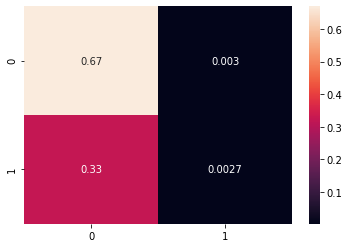

In [375]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, predTree)
print(cf_matrix)

import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True)

In [377]:
 c = df.corr()

s = c.unstack()
so = s.sort_values(kind="quicksort")
c['SEVERITYCODE'].sort_values()

VEHCOUNT         -0.054686
SDOTCOLNUM        0.004226
INTKEY            0.006553
X                 0.010309
Y                 0.017737
OBJECTID          0.020131
INCKEY            0.022065
COLDETKEY         0.022079
SEGLANEKEY        0.104276
PERSONCOUNT       0.130949
CROSSWALKKEY      0.175093
SDOT_COLCODE      0.188905
PEDCYLCOUNT       0.214218
PEDCOUNT          0.246338
SEVERITYCODE      1.000000
SEVERITYCODE.1    1.000000
Name: SEVERITYCODE, dtype: float64

In [378]:
import graphviz

In [245]:
# Create DOT data
dot_data = tree.export_graphviz(accidentTree, out_file=None, 
                                feature_names=FEATURES.columns)

# Draw graph
graph = graphviz.Source(dot_data)
graph.render("image",view=True)

'image.pdf'

In [ ]:
# Support Vector Machine
from sklearn import svm
kernels = ['linear','poly','rbf','sigmoid']
max_acc = 0.0
best_kernel = ''
for kernel in kernels:
    clf = svm.SVC(kernel=kernel)
    clf.fit(x_train, y_train) 
    target = clf.predict(x_test)
    mean_acc = metrics.accuracy_score(y_test, target)
    if mean_acc >= max_acc:
        best_kernel = kernel
        max_acc = mean_acc
        svm_targets = target

print(f"Most accurate kernel: {best_kernel}\nAccuracy: {max_acc}")

In [253]:
from sklearn.neighbors import KNeighborsClassifier
# KNN
max_k = 15
mean_acc = np.zeros((max_k-1))
std_acc = np.zeros((max_k-1))
confusion_matrix = [];
max_acc = 0.0;
most_accurate_k = 0;
for k in range(1,max_k): 
    neighbor = KNeighborsClassifier(n_neighbors = k).fit(x_train,y_train)
    target = neighbor.predict(x_test)
    mean       [ 1.03878933, -0.45079478, -0.23673079, -1.99031845, -1.5819356 ,
         0.69326132, -0.23809205]])
x_train, x_test, y_train, y_test = train_test_split(FEATURES, y, test_size=0.3, random_state=0)
from sklearn.tree import DecisionTreeClassifier
max_depth = 100
max_acc = 0.0
most_accurate_depth = 0
​
for depth in range(1, max_depth):
    accidentTree = DecisionTreeClassifier(criterion="entropy", max_depth = depth)
    accidentTree.fit(x_train,y_train)
    predTree = accidentTree.predict(x_test)
    if metrics.accuracy_score(y_test, predTree) >= max_acc:
        max_acc = metrics.accuracy_score(y_test, predTree)
        most_accurate_depth = depth
        decision_targets = predTree
        
print(f"Best Decision Tree Depth: {most_accurate_depth}\nAccuracy: {max_acc}")
Best Decision Tree Depth: 5
Accuracy: 0.672093949044586
 c = FEATURES.corr()

s = c.unstack()
so = s.sort_values(kind="quicksort")
c['SEVERITYCODE'].sort_values()
 c = FEATURES.corr()
​
s = c.unstack()
so = s.sort_values(kind="quicksort")
c['SEVERITYCODE'].sort_values()
WEATHER                -0.007544
ROADCOND               -0.003456
SPEEDING                0.026075
INATTENTIONIND          0.028435
UNDERINFL               0.031026
LIGHTCOND               0.033527
Intersection Related    0.166014
SEVERITYCODE            1.000000
Name: SEVERITYCODE, dtype: float64
import graphviz
# Create DOT data
dot_data = tree.export_graphviz(accidentTree, out_file=None, 
                                feature_names=FEATURES.columns)
​
# Draw graph
graph = graphviz.Source(dot_data)
graph.render("image",view=True)
'image.pdf'
# Support Vector Machine
from sklearn import svm
kernels = ['linear','poly','rbf','sigmoid']
max_acc = 0.0
best_kernel = ''
for kernel in kernels:
    clf = svm.SVC(kernel=kernel)
    clf.fit(x_train, y_train) 
    target = clf.predict(x_test)
    mean_acc = metrics.accuracy_score(y_test, target)
    if mean_acc >= max_acc:
        best_kernel = kernel
        max_acc = mean_acc
        svm_targets = target
​
print(f"Most accurate kernel: {best_kernel}\nAccuracy: {max_acc}")
Most accurate kernel: poly
Accuracy: 0.6720541401273885
from sklearn.neighbors import KNeighborsClassifier
# KNN
max_k = 15
mean_acc = np.zeros((max_k-1))
std_acc = np.zeros((max_k-1))
confusion_matrix = [];
max_acc = 0.0;
most_accurate_k = 0;
for k in range(1,max_k): 
    neighbor = KNeighborsClassifier(n_neighbors = k).fit(x_train,y_train)
    target = neighbor.predict(x_test)
    mean_acc[k-1] = metrics.accuracy_score(y_test, target)
    std_acc[k-1]=np.std(target==y_test)/np.sqrt(target.shape[0])
    if mean_acc[k-1] >= max_acc:
        most_accurate_k = k
        max_acc = mean_acc[k-1]
        knn_targets = target
​
print(f"Most accurate k: {most_accurate_k}\nAccuracy: {max_acc}")
Most accurate k: 2
Accuracy: 0.6677547770700637_acc[k-1] = metrics.accuracy_score(y_test, target)
    std_acc[k-1]=np.std(target==y_test)/np.sqrt(target.shape[0])
    if mean_acc[k-1] >= max_acc:
        most_accurate_k = k
        max_acc = mean_acc[k-1]
        knn_targets = target

print(f"Most accurate k: {most_accurate_k}\nAccuracy: {max_acc}")

Most accurate k: 2
Accuracy: 0.6677547770700637


In [247]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(x_train,y_train)
logistic_targets = LR.predict(x_test)
logistic_probs = LR.predict_proba(x_test)

In [251]:
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

# Logistic Regression Model Eval
f1s = f1_score(y_test, logistic_targets, average='weighted') 
ll = log_loss(y_test, logistic_probs)
print(f"Logistic Regression\nJaccard Similarity Score: jss\nF1 Score: {f1s}\nLog Loss: {ll}")

Logistic Regression
Jaccard Similarity Score: jss
F1 Score: 0.5452140655539377
Log Loss: 0.6167129241349958


In [296]:
# Let's keep the 5 attributes with the highest correlation and see how that affects our results. 
# Suprisingly weather and road conditions had little affect. It was being under the influence or at an intersection 
# that increased the probability of a fatal accident
#FEATURES = FEATURES.drop(['WEATHER','ROADCOND'], axis=1)


In [298]:
#x_train, x_test, y_train, y_test = train_test_split(FEATURES, y, test_size=0.3, random_state=0)

In [312]:
max_depth = 100
max_acc = 0.0
most_accurate_depth = 0

for depth in range(1, max_depth):
    accidentTree = DecisionTreeClassifier(criterion="entropy", max_depth = depth)
    accidentTree.fit(x_train,y_train)
    predTree = accidentTree.predict(x_test)
    if metrics.accuracy_score(y_test, predTree) > max_acc:
        max_acc = metrics.accuracy_score(y_test, predTree)
        most_accurate_depth = depth
        decision_targets = predTree
        
print(f"Best Decision Tree Depth: {most_accurate_depth}\nAccuracy: {max_acc}")

# Here we have an accuracy of 100% at a depth of 99

# Create DOT data
dot_data = tree.export_graphviz(accidentTree, out_file=None, 
                                feature_names=FEATURES.columns)

# Draw graph
graph = graphviz.Source(dot_data)
graph.render("image",view=True)

Best Decision Tree Depth: 1
Accuracy: 0.6719745222929936


'image.pdf'

In [311]:
pd.crosstab(index=df['SEVERITYCODE'],
           columns=FEATURES['LIGHTCOND'],
           normalize='index')

LIGHTCOND,0,1,2
SEVERITYCODE,,,
1,0.016188,0.331059,0.652753
2,0.011256,0.304786,0.683958


In [326]:
df[['SEVERITYCODE','WEATHER','ROADCOND']].groupby(['WEATHER','ROADCOND'], as_index=False).mean().pivot(index='WEATHER',columns='ROADCOND')

SEVERITYCODE                                \
ROADCOND                          Dry       Ice       Oil     Other   
WEATHER                                                               
Blowing Sand/Dirt            1.281250  1.000000       NaN  2.000000   
Clear                        1.323639  1.261682  1.631579  1.400000   
Fog/Smog/Smoke               1.337989  1.400000       NaN  1.000000   
Other                        1.292553  1.263158  1.000000  1.200000   
Overcast                     1.318151  1.213333  1.375000  1.333333   
Partly Cloudy                1.500000       NaN       NaN       NaN   
Raining                      1.318253  1.428571  1.272727  1.444444   
Severe Crosswind             1.300000  1.333333       NaN       NaN   
Sleet/Hail/Freezing Rain     1.500000  1.166667       NaN  1.000000   
Snowing                      1.333333  1.142012       NaN  2.000000   
Unknown                      1.150831  1.054054  1.000000  1.000000   

                                                                            \
ROADCOND                 Sand/Mud/Dirt Snow/Slush Standing Water   Unknown   
WEATHER                                                                      
Blowing Sand/Dirt                  NaN   1.200000            NaN  1.000000   
Clear                         1.424242   1.231579       1.142857  1.109804   
Fog/Smog/Smoke                1.500000   1.000000            NaN  1.285714   
Other                         1.000000   1.000000            NaN  1.061338   
Overcast                      1.235294   1.135338       1.571429  1.138418   
Partly Cloudy                      NaN        NaN            NaN       NaN   
Raining                       1.272727   1.250000       1.274725  1.210526   
Severe Crosswind                   NaN        NaN            NaN       NaN   
Sleet/Hail/Freezing Rain           NaN   1.259259       1.000000       NaN   
Snowing                       1.000000   1.164234            NaN  1.125000   
Unknown                       1.125000   1.054348       1.000000  1.044082   

                                    
ROADCOND                       Wet  
WEATHER                             
Blowing Sand/Dirt         1.500000  
Clear                     1.328147  
Fog/Smog/Smoke            1.300613  
Other                     1.323077  
Overcast                  1.321860  
Partly Cloudy             2.000000  
Raining                   1.338135  
Severe Crosswind          1.250000  
Sleet/Hail/Freezing Rain  1.267857  
Snowing                   1.303226  
Unknown                   1.181818

In [355]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

In [381]:
# Decision Tree Model Eval
jss = jaccard_score(y_test, decision_targets)
f1s = f1_score(y_test, decision_targets, average='weighted') 
print(f"Logistic Regression\nJaccard Similarity Score: {jss}\nF1 Score: {f1s}")

Logistic Regression
Jaccard Similarity Score: 0.6711448248328177
F1 Score: 0.5454149460349641


In [357]:
# KNN Model Eval
jss = jaccard_score(y_test, knn_targets)
f1s = f1_score(y_test, knn_targets, average='weighted') 
print(f"Logistic Regression\nJaccard Similarity Score: {jss}\nF1 Score: {f1s}")

Logistic Regression
Jaccard Similarity Score: 0.6652360515021459
F1 Score: 0.5510997939481097


In [358]:
# Logistic Regression Model Eval
jss = jaccard_score(y_test, logistic_targets)
f1s = f1_score(y_test, logistic_targets, average='weighted') 
ll = log_loss(y_test, logistic_probs)
print(f"Logistic Regression\nJaccard Similarity Score: {jss}\nF1 Score: {f1s}\nLog Loss: {ll}")

Logistic Regression
Jaccard Similarity Score: 0.6710513183895886
F1 Score: 0.5452140655539377
Log Loss: 0.6167129241349958


In [359]:
# SVM Model Eval
jss = jaccard_score(y_test, svm_targets)
f1s = f1_score(y_test, svm_targets, average='weighted') 
print(f"Logistic Regression\nJaccard Similarity Score: {jss}\nF1 Score: {f1s}")

Logistic Regression
Jaccard Similarity Score: 0.6716816451786461
F1 Score: 0.5422527570310235
